# Introduction

This notebook accompanies the thesis **“SQL-Centric Optimization of Backtesting and Feature Engineering for Trading Strategies: Benchmarking Against Python Using Vietnamese Stock Market Data.”**

**Objective.** The study evaluates how trading features and backtests can be computed in **SQL** versus **Python**.

**Scope.** Daily **OHLCV** data for Vietnamese equities (2000–2025) are used.

## Data & Assumptions

**Data fields.** `symbol, date, open, high, low, close, volume`.

**Calendar.** Dates are aligned to the VN trading calendar; weekends and official holidays are excluded.

**Coverage and bias.**
- Survivorship bias may exist if delisted tickers are absent.
- Corporate actions (splits/dividends) are not adjusted in this.

**Purpose.** This data section establishes a **single, canonical input** used by both SQL and Python pipelines to ensure fair comparison.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from pathlib import Path
pio.renderers.default = "notebook"

In [2]:
# Read from current notebook folder
prices = pd.read_csv(
    "prices_all.csv",
    parse_dates=["date"],
    dtype={"symbol": "string"},
    dayfirst=True
).sort_values(["symbol","date"], ignore_index=True)

# Quick sanity check
display(prices.head())

,symbol,date,open,high,low,close,volume
0,BID,2014-01-24,18.8,19.5,18.5,18.8,"5,279,630,000.00"
1,BID,2014-01-27,18.8,18.8,18.1,18.8,"622,914,000.00"
2,BID,2014-02-06,18.4,18.4,17.6,18.4,"278,430,000.00"
3,BID,2014-02-07,17.6,17.6,16.5,17.6,"302,520,000.00"
4,BID,2014-02-10,16.6,17.2,16.2,16.6,"14,165,667,000.00"


## Exploratory Data Summary

The following quick EDA validates the dataset used for benchmarking:

- row and column counts,
- number of unique symbols,
- date range,
- missing-value report per column,
- descriptive statistics for numeric fields.

In [3]:
# 1. General dataset summary
eda_summary = pd.DataFrame({
    "Rows": [len(prices)],
    "Columns": [prices.shape[1]],
    "Missing values (total)": [prices.isna().to_numpy().sum()],
    "Unique symbols": [prices["symbol"].nunique()],
    "Date range": [f"{prices['date'].min().date()} → {prices['date'].max().date()}"]
})
display(eda_summary)

# 2. Missing values per column
display(prices.isna().sum().to_frame("Missing Values"))

# 3. Numeric stats
display(prices.describe(include="number").T)


,Rows,Columns,Missing values (total),Unique symbols,Date range
0,107294,7,0,30,2000-07-28 → 2025-10-03


,Missing Values
symbol,0
date,0
open,0
high,0
low,0
close,0
volume,0


,count,mean,std,min,25%,50%,75%,max
open,107294.0,51.591537,43.578290,4.55,22.95,38.7,66.3,665.0
high,107294.0,52.329233,44.208687,4.84,23.30,39.2,67.1,672.0
low,107294.0,50.963384,43.107711,0.10,22.65,38.2,65.5,665.0
close,107294.0,51.591537,43.578290,4.55,22.95,38.7,66.3,665.0


## Price Visualization

A **candlestick chart** provides a first view of trend and volatility for a selected ticker (e.g., `VNM`):

- Green candles: close ≥ open (bullish days).
- Red candles: close < open (bearish days).
- Bodies show open–close ranges; wicks show intraday highs and lows.

This plot serves as a sanity check before feature engineering and backtesting.

In [5]:
# Filter data for a single symbol (e.g., VNM)
df_vnm = prices.loc[prices["symbol"] == "VNM"].copy()

# Create candlestick chart with Plotly
fig = go.Figure(go.Candlestick(
    x=df_vnm["date"],
    open=df_vnm["open"],
    high=df_vnm["high"],
    low=df_vnm["low"],
    close=df_vnm["close"],
    name="VNM"  # legend label
))

fig.update_layout(
    title="VNM Candlestick Chart",
    xaxis_title="Date",
    yaxis_title="Price (VND)",
    xaxis_rangeslider_visible=False,
    template="plotly_white"  # clean academic style
)
fig.show()

# Methodology

The methodology follows three layers:

1) **Feature Engineering.** Indicators are computed with vectorized Python code and **mirrored in SQL** (views/UDFs).  
2) **Backtesting.** Strategies consume those features under a common execution model.  
3) **Benchmarking.** SQL and Python pipelines are compared on identical inputs and configuration.

# Simple vs Log Returns

**Simple return:** It measures the percentage change in price from one period to the next.

$$
R_t = \frac{P_t}{P_{t-1}} - 1
$$

**Logarithmic return:** Log returns are additive over time and often used in quantitative finance.


$$
r_t = \ln\!\left(\frac{P_t}{P_{t-1}}\right)
$$



symbol       date  close  simple_return
   BID 2014-01-24   18.8            NaN
   BID 2014-01-27   18.8       0.000000
   BID 2014-02-06   18.4      -0.021277
   BID 2014-02-07   17.6      -0.043478
   BID 2014-02-10   16.6      -0.056818
   BID 2014-02-11   17.0       0.024096
   BID 2014-02-12   16.9      -0.005882
   BID 2014-02-13   16.8      -0.005917
   BID 2014-02-14   16.6      -0.011905
   BID 2014-02-17   16.8       0.012048


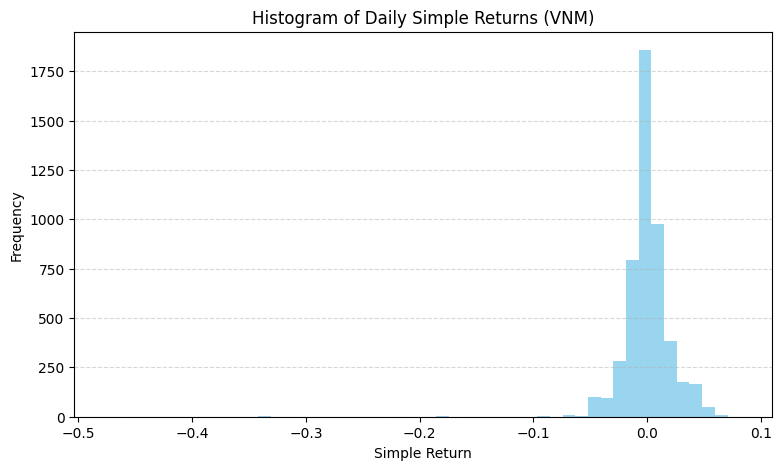

In [7]:
# --- Simple Return ---
prices["simple_return"] = prices.groupby("symbol")["close"].pct_change()
print(prices[["symbol","date","close","simple_return"]].head(10).to_string(index=False))

d = prices[prices["symbol"]=="VNM"].sort_values("date")
d["simple_return"].dropna().plot.hist(bins=50, color="skyblue", alpha=0.85, figsize=(9,5),
                                      title="Histogram of Daily Simple Returns (VNM)")
plt.xlabel("Simple Return"); plt.ylabel("Frequency"); plt.grid(axis="y", ls="--", alpha=0.5)
plt.show()


symbol       date  close  log_return
   BID 2014-01-24   18.8         NaN
   BID 2014-01-27   18.8    0.000000
   BID 2014-02-06   18.4   -0.021506
   BID 2014-02-07   17.6   -0.044452
   BID 2014-02-10   16.6   -0.058496
   BID 2014-02-11   17.0    0.023811
   BID 2014-02-12   16.9   -0.005900
   BID 2014-02-13   16.8   -0.005935
   BID 2014-02-14   16.6   -0.011976
   BID 2014-02-17   16.8    0.011976


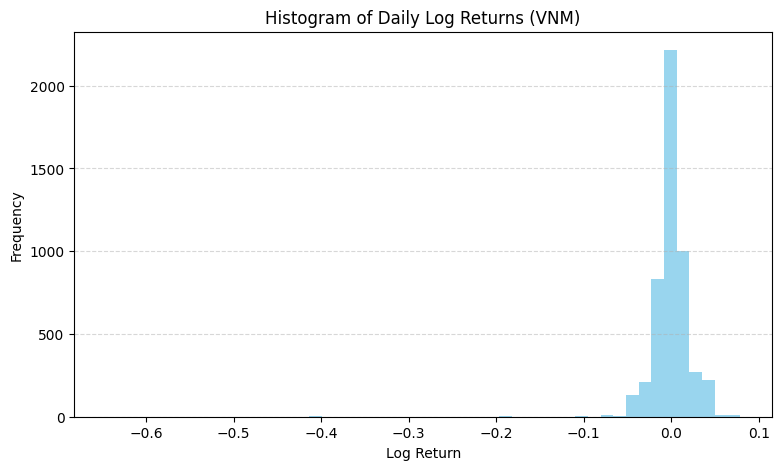

In [8]:
# --- Log Return ---
prices["log_return"] = prices.groupby("symbol")["close"] \
                             .transform(lambda s: np.log(s).diff())
print(prices[["symbol","date","close","log_return"]].head(10).to_string(index=False))

d = prices[prices["symbol"]=="VNM"].sort_values("date")
d["log_return"].dropna().plot.hist(bins=50, color="skyblue", alpha=0.85, figsize=(9,5),
                                   title="Histogram of Daily Log Returns (VNM)")
plt.xlabel("Log Return"); plt.ylabel("Frequency"); plt.grid(axis="y", ls="--", alpha=0.5)
plt.show()

### Cumulative Returns

Cumulative return measures the total growth of an investment over time.  
It can be defined in compounding form:

$$
CR_t = \prod_{i=1}^{t}(1+R_i) - 1
$$

where \(Ri\) is the simple return at period \(i\).

In the special case where only the initial and final prices are considered, it simplifies to:

$$
CR_t = \frac{P_t}{P_0} - 1
$$

symbol       date  close  cumulative_return
   BID 2014-01-24   18.8           0.000000
   BID 2014-01-27   18.8           0.000000
   BID 2014-02-06   18.4          -0.021277
   BID 2014-02-07   17.6          -0.063830
   BID 2014-02-10   16.6          -0.117021
   BID 2014-02-11   17.0          -0.095745
   BID 2014-02-12   16.9          -0.101064
   BID 2014-02-13   16.8          -0.106383
   BID 2014-02-14   16.6          -0.117021
   BID 2014-02-17   16.8          -0.106383


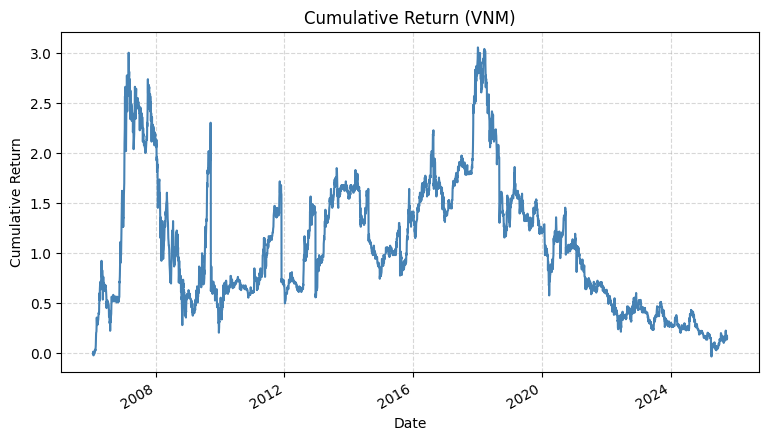

In [9]:
# --- Cumulative Return ---
prices["cumulative_return"] = prices.groupby("symbol")["close"].transform(lambda s: s / s.iloc[0] - 1)
print(prices[["symbol","date","close","cumulative_return"]].head(10).to_string(index=False))

d = prices[prices["symbol"]=="VNM"].sort_values("date")
d.plot(x="date", y="cumulative_return", figsize=(9,5), legend=False,
       title="Cumulative Return (VNM)", color="steelblue")
plt.xlabel("Date"); plt.ylabel("Cumulative Return"); plt.grid(ls="--", alpha=0.5)
plt.show()

### Annualized Return

Annualized return scales the investment performance to a yearly horizon.  

**Geometric definition (exact):**
$$
AR = \left(\prod_{i=1}^{n}(1+R_i)\right)^{\tfrac{252}{n}} - 1
$$

where Ri are the daily returns and \(n\) is the number of trading days observed.

**Approximation (arithmetic):**
$$
AR \approx \bar{R}_{daily} \times 252
$$

**From log returns (equivalent):**
$$
AR = \exp\!\big(\overline{r_{\log}} \cdot 252\big) - 1
$$

In [10]:
g = prices.groupby("symbol", sort=False)["close"]
ann = (
    g.agg(first="first", last="last", n="size")
     .assign(annualized=lambda x: (x["last"]/x["first"])**(252/x["n"]) - 1)
     .reset_index()[["symbol","annualized"]]
)
print(ann.head(10).to_string(index=False))

symbol  annualized
   BID    0.067472
   BVH    0.009372
   CTG    0.015448
   DGC    0.080840
   DXG   -0.054509
   FPT   -0.075838
   GAS    0.029413
   GEX    0.097147
   GMD    0.019135
   HCM   -0.012421


# Volatility

Volatility measures the dispersion of daily returns.  
It is computed as the standard deviation of daily returns:

$$
\sigma_{daily} = \text{Std}(R_t)
$$

Annualized volatility assumes 252 trading days:

$$
\sigma_{annual} = \sigma_{daily} \times \sqrt{252}
$$

A rolling 20-day window can be used to observe short-term changes in risk.

In [11]:
# --- Volatility (daily & annualized) ---
prices["log_return"] = prices.groupby("symbol", sort=False)["close"].transform(lambda s: np.log(s).diff())

vol = (
    prices.dropna(subset=["log_return"])
          .groupby("symbol", sort=False)["log_return"]
          .std()
          .reset_index(name="daily_vol")
)

vol["annual_vol"] = vol["daily_vol"] * np.sqrt(252)

print(vol.head(10).to_string(index=False))

sym = "VNM"
dv = vol.loc[vol["symbol"]==sym, "daily_vol"].iloc[0]
av = vol.loc[vol["symbol"]==sym, "annual_vol"].iloc[0]
print(f"Daily Volatility ({sym}): {dv:.2%}")
print(f"Annualized Volatility ({sym}): {av:.2%}")

symbol  daily_vol  annual_vol
   BID   0.023025    0.365507
   BVH   0.024693    0.391991
   CTG   0.022309    0.354151
   DGC   0.029197    0.463484
   DXG   0.032071    0.509118
   FPT   0.023604    0.374708
   GAS   0.021215    0.336775
   GEX   0.027708    0.439852
   GMD   0.024710    0.392258
   HCM   0.030826    0.489354
Daily Volatility (VNM): 2.28%
Annualized Volatility (VNM): 36.12%


### Rolling Annualized Volatility

Annualized volatility measures the dispersion of returns, scaled to a yearly basis.  
The rolling version captures how risk evolves over different time windows.

For a rolling window of length \(n\):

$$
\sigma_{t}^{(n)} = \operatorname{Std}\!\big(\ell_{t-n+1}, \dots, \ell_t \big) \times \sqrt{252}
$$

where 
$$
\ell_t = \ln\!\left(\frac{P_t}{P_{t-1}}\right)
$$
is the log return.

In practice, we can compute and plot rolling volatilities with different horizons (e.g., 30-day, 60-day) to observe changing market risk levels.


symbol       date  log_return  roll_vol_30  roll_vol_60
   BID 2014-05-05    0.006349     0.226490     0.239896
   BID 2014-05-06   -0.012739     0.224894     0.240658
   BID 2014-05-07   -0.025975     0.205032     0.242286
   BID 2014-05-08    0.019545     0.207385     0.230963
   BID 2014-05-09   -0.059818     0.261867     0.232353
   BID 2014-05-12    0.013606     0.265919     0.228393
   BID 2014-05-13   -0.055570     0.298958     0.253078
   BID 2014-05-14    0.007117     0.297301     0.253874
   BID 2014-05-15    0.041673     0.327422     0.269054
   BID 2014-05-16   -0.034606     0.334928     0.275557


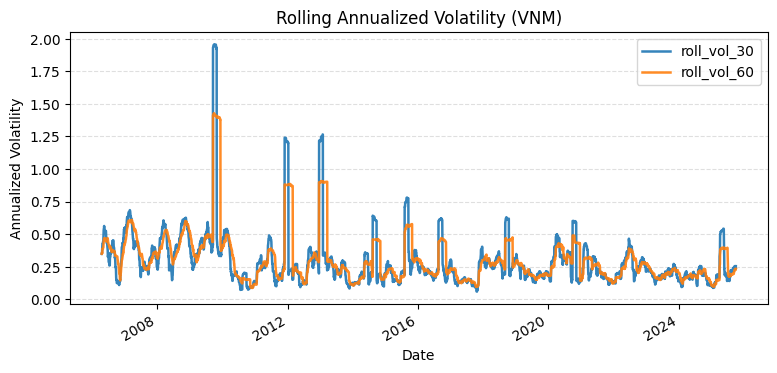

In [12]:
# --- Rolling Annualized Volatility ---
prices = prices.sort_values(["symbol","date"]).reset_index(drop=True)
g = prices.groupby("symbol", sort=False)

prices["log_return"] = g["close"].transform(lambda s: np.log(s).diff())
prices["roll_vol_30"] = g["log_return"].transform(lambda s: s.rolling(30, min_periods=30).std() * np.sqrt(252))
prices["roll_vol_60"] = g["log_return"].transform(lambda s: s.rolling(60, min_periods=60).std() * np.sqrt(252))

mask = prices["roll_vol_30"].notna() & prices["roll_vol_60"].notna()
print(prices.loc[mask, ["symbol","date","log_return","roll_vol_30","roll_vol_60"]]
           .head(10).to_string(index=False))

sym = "VNM"
d = prices.loc[prices["symbol"]==sym].dropna(subset=["roll_vol_30","roll_vol_60"])
ax = d.plot(x="date", y=["roll_vol_30","roll_vol_60"], figsize=(9,4), lw=1.8, alpha=0.9,
            title=f"Rolling Annualized Volatility ({sym})")
ax.set_xlabel("Date"); ax.set_ylabel("Annualized Volatility")
ax.grid(axis="y", ls="--", alpha=0.4)
plt.show()

## Simple Moving Average (SMA)
$$
\mathrm{SMA}_n(t) = \frac{1}{n}\sum_{i=0}^{n-1} P_{t-i}
$$
- Arithmetic mean of the last n closes.  
- Smooths noise; longer n = slower but more stable trend.

symbol       date  close  SMA20  SMA50
   BID 2014-04-15   16.7 16.940 16.932
   BID 2014-04-16   16.5 16.935 16.886
   BID 2014-04-17   16.0 16.895 16.830
   BID 2014-04-18   16.1 16.830 16.784
   BID 2014-04-21   15.9 16.740 16.750
   BID 2014-04-22   15.5 16.640 16.728
   BID 2014-04-23   15.8 16.550 16.704
   BID 2014-04-24   15.8 16.480 16.682
   BID 2014-04-25   15.9 16.435 16.664
   BID 2014-04-28   15.7 16.380 16.646


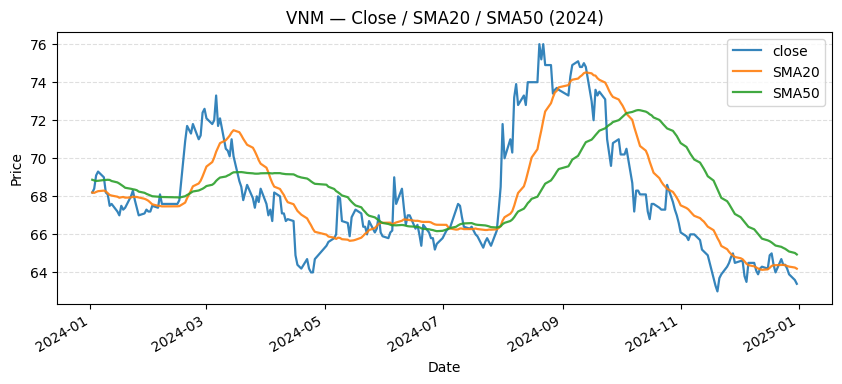

In [13]:
# --- SMA ---
g = prices.groupby("symbol")["close"]
prices["SMA20"] = g.transform(lambda s: s.rolling(20, min_periods=20).mean())
prices["SMA50"] = g.transform(lambda s: s.rolling(50, min_periods=50).mean())

mask = prices["SMA20"].notna() & prices["SMA50"].notna()
print(prices.loc[mask, ["symbol","date","close","SMA20","SMA50"]]
           .head(10).to_string(index=False))

SYM, START, END = "VNM", "2024-01-01", "2025-01-01"
d = prices[(prices["symbol"]==SYM) & (prices["date"]>=START) & (prices["date"]<END)].dropna(subset=["SMA50"])
d.plot(x="date", y=["close","SMA20","SMA50"], figsize=(10,4), linewidth=1.6, alpha=0.9,
       title=f"{SYM} — Close / SMA20 / SMA50 (2024)")
plt.xlabel("Date"); plt.ylabel("Price")
plt.grid(axis="y", ls="--", alpha=0.4)
plt.show()

## Exponential Moving Average (EMA)

The EMA is a weighted moving average that gives higher importance to recent prices.  
It reacts faster than the simple moving average (SMA), making it useful for trend detection.

The recursive formula for EMA with window \(n\) is:

$$
\mathrm{EMA}_n(t) = \alpha P_t + (1-\alpha)\,\mathrm{EMA}_n(t-1), 
\quad \alpha = \frac{2}{n+1}
$$

- **EMA(12)**: short-term moving average.  
- **EMA(26)**: longer-term moving average.  
- The **crossover** between EMA12 and EMA26 is often used to identify trend shifts:
  - EMA12 > EMA26 → bullish momentum.  
  - EMA12 < EMA26 → bearish momentum.

symbol       date  close     EMA12     EMA26
   BID 2014-03-11   16.7 16.736772 17.072373
   BID 2014-03-12   16.6 16.715730 17.037382
   BID 2014-03-13   16.5 16.682541 16.997576
   BID 2014-03-14   16.5 16.654458 16.960718
   BID 2014-03-17   16.6 16.646080 16.933999
   BID 2014-03-18   16.6 16.638991 16.909258
   BID 2014-03-19   16.8 16.663761 16.901165
   BID 2014-03-20   17.4 16.777029 16.938116
   BID 2014-03-21   17.7 16.919024 16.994551
   BID 2014-03-24   17.5 17.008405 17.031992


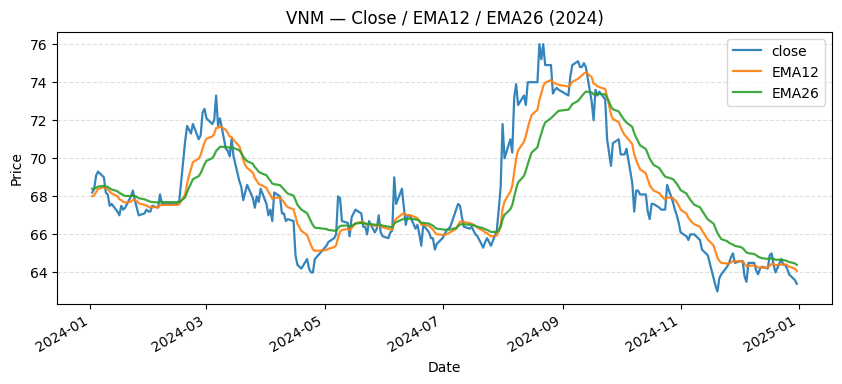

In [19]:
# --- EMA ---
g = prices.groupby("symbol")["close"]
prices["EMA12"] = g.transform(lambda s: s.ewm(span=12, adjust=False, min_periods=12).mean())
prices["EMA26"] = g.transform(lambda s: s.ewm(span=26, adjust=False, min_periods=26).mean())

mask = prices["EMA12"].notna() & prices["EMA26"].notna()
print(prices.loc[mask, ["symbol","date","close","EMA12","EMA26"]]
           .head(10).to_string(index=False))

d = prices[(prices["symbol"]==SYM) & (prices["date"]>=START) & (prices["date"]<END)].dropna(subset=["EMA26"])
d.plot(x="date", y=["close","EMA12","EMA26"], figsize=(10,4), linewidth=1.6, alpha=0.9,
       title=f"{SYM} — Close / EMA12 / EMA26 (2024)")
plt.xlabel("Date"); plt.ylabel("Price")
plt.grid(axis="y", ls="--", alpha=0.4)
plt.show()

## Moving Average Convergence Divergence (MACD)

The MACD is a momentum indicator based on the difference between two exponential moving averages (EMA).  
It highlights trend direction, momentum strength, and potential reversals.

Formally, with fast window \(n_f\), slow window \(n_s\), and signal window \(n_{sig}\):

$$
MACD_t = EMA_{t}^{(n_f)} - EMA_{t}^{(n_s)}
$$

$$
Signal_t = EMA_{t}^{(n_{sig})}(MACD_t)
$$

$$
Hist_t = MACD_t - Signal_t
$$

- **MACD line**: difference of short-term and long-term EMA (e.g., 12 vs. 26 days).  
- **Signal line**: smoothing of MACD (e.g., 9-day EMA)


symbol       date      MACD    Signal      Hist
   BID 2014-03-21 -0.075527 -0.228912  0.153385
   BID 2014-03-24 -0.023587 -0.187847  0.164260
   BID 2014-03-25  0.025353 -0.145207  0.170560
   BID 2014-03-26  0.031499 -0.109866  0.141364
   BID 2014-03-27  0.004046 -0.087084  0.091129
   BID 2014-03-28 -0.017509 -0.073169  0.055660
   BID 2014-03-31 -0.018243 -0.062184  0.043941
   BID 2014-04-01 -0.034564 -0.056660  0.022095
   BID 2014-04-02 -0.054935 -0.056315  0.001380
   BID 2014-04-03 -0.070269 -0.059106 -0.011163


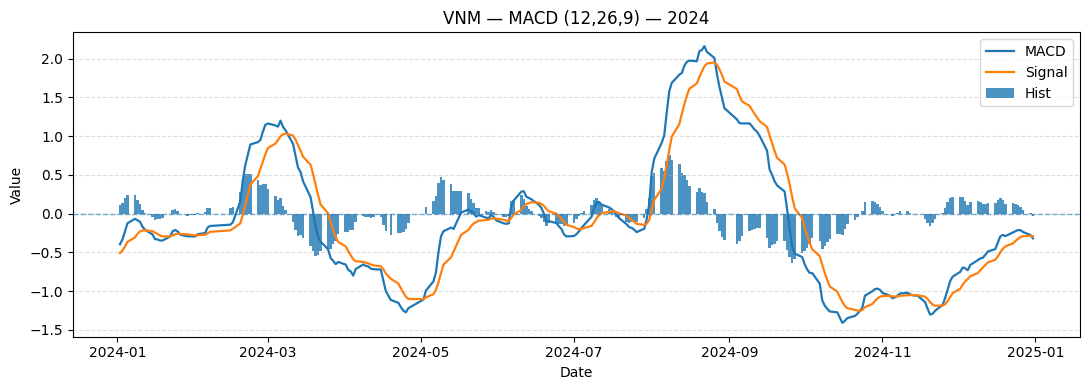

In [20]:
# --- MACD (12,26,9): market → preview → visualize VNM for 2024 ---
def ema(s, span): return s.ewm(span=span, adjust=False, min_periods=span).mean()

g = prices.groupby("symbol")
prices["EMA12"]  = g["close"].transform(lambda s: ema(s, 12))
prices["EMA26"]  = g["close"].transform(lambda s: ema(s, 26))
prices["MACD"]   = prices["EMA12"] - prices["EMA26"]
prices["Signal"] = g["MACD"].transform(lambda s: ema(s, 9))
prices["Hist"]   = prices["MACD"] - prices["Signal"]

mask = prices["Hist"].notna()
print(prices.loc[mask, ["symbol","date","MACD","Signal","Hist"]]
           .head(10).to_string(index=False))

sym, start, end = "VNM", pd.Timestamp("2024-01-01"), pd.Timestamp("2025-01-01")
d = (prices[(prices["symbol"]==sym) & (prices["date"]>=start) & (prices["date"]<end)]
            .dropna(subset=["Hist"]).sort_values("date"))

plt.figure(figsize=(11,4))
plt.bar(d["date"], d["Hist"], width=1.0, alpha=0.8, label="Hist")
plt.plot(d["date"], d["MACD"],  lw=1.6, label="MACD")
plt.plot(d["date"], d["Signal"], lw=1.6, label="Signal")
plt.axhline(0, ls="--", lw=1, alpha=0.6)
plt.grid(axis="y", ls="--", alpha=0.4)
plt.title(f"{sym} — MACD (12,26,9) — 2024")
plt.xlabel("Date"); plt.ylabel("Value")
plt.legend(); plt.tight_layout(); plt.show()

## Relative Strength Index (RSI, Wilder)

First define price changes:

$$
\Delta P_t = P_t - P_{t-1}, 
\quad U_t = \max(\Delta P_t, 0), 
\quad D_t = \max(-\Delta P_t, 0)
$$

Wilder’s smoothed mean (RMA):

$$
RMA_n(X)_t = RMA_n(X)_{t-1} + \frac{1}{n}\Big( X_t - RMA_n(X)_{t-1} \Big)
$$

Then RSI is:

$$
RSI_n(t) = 100 - \frac{100}{1 + \frac{RMA_n(U)_t}{RMA_n(D)_t}}
$$

- Typical window: \(n = 14\).  
- RSI > 70 → overbought, RSI < 30 → oversold.  
- Divergences may indicate potential reversals.


symbol       date  RSI14_Wilder
   BID 2014-02-24     23.076923
   BID 2014-02-25     23.076923
   BID 2014-02-26     23.076923
   BID 2014-02-27     23.076923
   BID 2014-02-28     28.040473
   BID 2014-03-03     30.456743
   BID 2014-03-04     27.476049
   BID 2014-03-05     26.543534
   BID 2014-03-06     26.543534
   BID 2014-03-07     26.543534


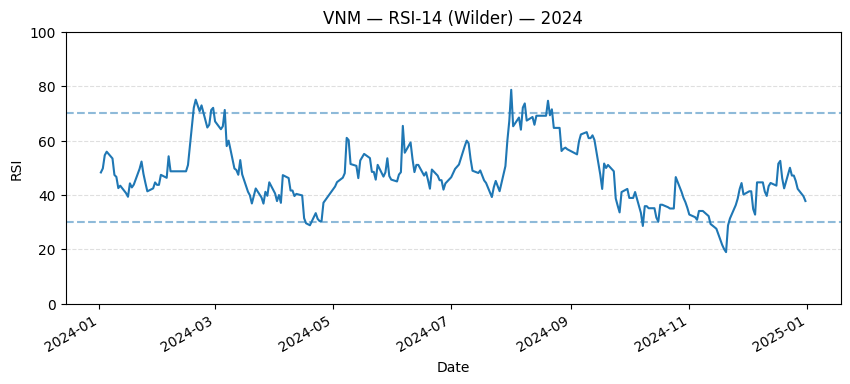

In [17]:
n = 14
g = prices.groupby("symbol", sort=False)

def rsi_wilder_strict(close: pd.Series, n: int = 14) -> pd.Series:
    delta = close.diff()
    gain  = delta.clip(lower=0)
    loss  = (-delta).clip(lower=0)

    avg_gain = gain.rolling(n, min_periods=n).mean()
    avg_loss = loss.rolling(n, min_periods=n).mean()
    for i in range(n+1, len(close)):
        avg_gain.iat[i] = (avg_gain.iat[i-1]*(n-1) + gain.iat[i]) / n
        avg_loss.iat[i] = (avg_loss.iat[i-1]*(n-1) + loss.iat[i]) / n

    ag, al = avg_gain.to_numpy(float), avg_loss.to_numpy(float)
    rs = np.divide(ag, al, out=np.zeros_like(ag), where=(al!=0))
    rsi = 100 - 100/(1+rs)
    rsi[(al==0) & (ag>0)] = 100.0
    rsi[(al==0) & (ag==0)] = 50.0
    return pd.Series(rsi, index=close.index)

prices["RSI14_Wilder"] = g["close"].transform(lambda s: rsi_wilder_strict(s, n))

m = prices["RSI14_Wilder"].notna()
print(prices.loc[m, ["symbol","date","RSI14_Wilder"]].head(10).to_string(index=False))

sym, start, end = "VNM", "2024-01-01", "2025-01-01"
d = prices[(prices["symbol"]==sym) & (prices["date"]>=start) & (prices["date"]<end)].dropna(subset=["RSI14_Wilder"])
d.plot(x="date", y="RSI14_Wilder", figsize=(10,4), legend=False,
       title=f"{sym} — RSI-14 (Wilder) — 2024")
plt.axhline(70, ls="--", alpha=0.5); plt.axhline(30, ls="--", alpha=0.5)
plt.ylim(0,100); plt.xlabel("Date"); plt.ylabel("RSI"); plt.grid(axis="y", ls="--", alpha=0.4)
plt.show()

## Rate of Change

The Rate of Change (ROC) measures the relative change in price compared to the price \(n\) periods ago.  
It is a momentum oscillator that oscillates around zero.

For a window length \(n\):

$$
ROC_t^{(n)} = \frac{P_t}{P_{t-n}} - 1
$$

- ROC > 0 → prices are higher than \(n\) periods ago (upward momentum).  
- ROC < 0 → prices are lower than \(n\) periods ago (downward momentum).  
- Crosses of the zero line can signal momentum shifts.

*Note:* Some charting tools multiply the formula by 100 to display percentages.  
In this notebook we keep the **ratio form** to match the SQL implementation.  
Typical setting: \(n = 14\).


symbol       date     ROC14
   BID 2014-02-24 -0.111702
   BID 2014-02-25 -0.111702
   BID 2014-02-26 -0.092391
   BID 2014-02-27 -0.051136
   BID 2014-02-28  0.018072
   BID 2014-03-03  0.000000
   BID 2014-03-04 -0.011834
   BID 2014-03-05 -0.011905
   BID 2014-03-06  0.000000
   BID 2014-03-07 -0.011905


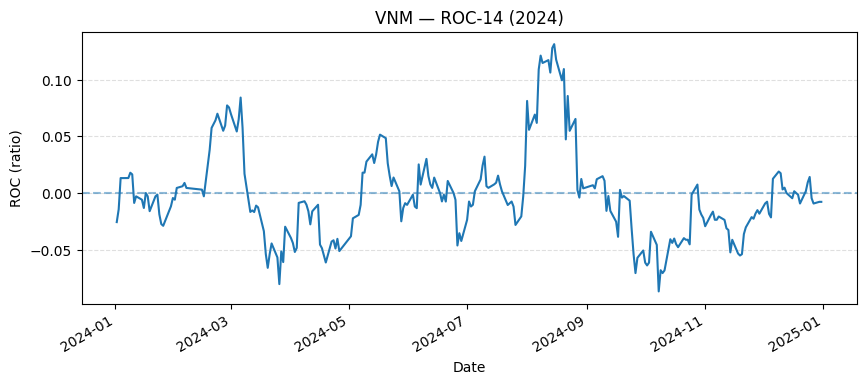

In [22]:
# --- ROC-14 ---
n = 14
g = prices.groupby("symbol", sort=False)["close"]
prices["ROC14"] = g.transform(lambda s: s / s.shift(n) - 1)

m = prices["ROC14"].notna()
print(prices.loc[m, ["symbol","date","ROC14"]].head(10).to_string(index=False))

sym, start, end = "VNM", "2024-01-01", "2025-01-01"
d = prices[(prices["symbol"]==sym) & (prices["date"]>=start) & (prices["date"]<end)].dropna(subset=["ROC14"])
d.plot(x="date", y="ROC14", figsize=(10,4), legend=False, title=f"{sym} — ROC-14 (2024)")
plt.axhline(0, ls="--", alpha=0.5)
plt.xlabel("Date"); plt.ylabel("ROC (ratio)")
plt.grid(axis="y", ls="--", alpha=0.4)
plt.show()

## Bollinger Bands

Bollinger Bands consist of a moving average with upper and lower bands placed at a multiple of the standard deviation.  
They capture both trend and volatility.

For window length \(n = 20\) and multiplier \(k = 2\):

$$
MA_t = \frac{1}{n}\sum_{i=0}^{n-1} P_{t-i}
$$

$$
BB_{upper,t} = MA_t + k \cdot \sigma_t,
\qquad 
BB_{lower,t} = MA_t - k \cdot \sigma_t
$$

where ($sigma_t$) is the rolling standard deviation of prices.


- Price near **upper band** → potentially overbought.  
- Price near **lower band** → potentially oversold.  
- **Band squeeze** (narrow width) → low volatility, may precede breakout.  
- **Breakout**: price closes outside bands, may indicate strong directional move.  

Typical setting: \(n=20, k=2\).

symbol       date  close  BB_MA20     BB_UP     BB_LO
   BID 2014-03-03   17.0   17.090 18.492712 15.687288
   BID 2014-03-04   16.7   16.985 18.155085 15.814915
   BID 2014-03-05   16.6   16.875 17.706565 16.043435
   BID 2014-03-06   16.6   16.785 17.242275 16.327725
   BID 2014-03-07   16.6   16.735 17.005370 16.464630
   BID 2014-03-10   16.6   16.735 17.005370 16.464630
   BID 2014-03-11   16.7   16.720 16.961661 16.478339
   BID 2014-03-12   16.6   16.705 16.937164 16.472836
   BID 2014-03-13   16.5   16.690 16.934131 16.445869
   BID 2014-03-14   16.5   16.685 16.940147 16.429853


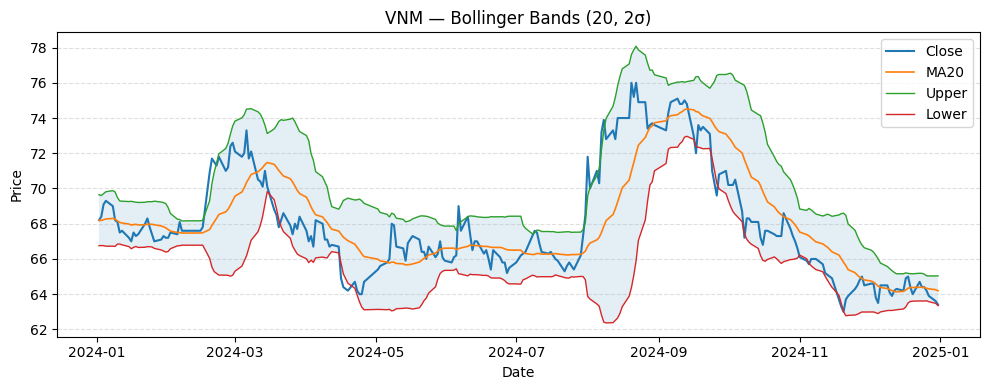

In [18]:
# --- Bollinger Bands (20, 2σ) ---
SYM, START, END = "VNM", "2024-01-01", "2025-01-01"

g = prices.groupby("symbol", sort=False)["close"]
prices["BB_MA20"] = g.transform(lambda s: s.rolling(20, min_periods=20).mean())
prices["BB_STD"]  = g.transform(lambda s: s.rolling(20, min_periods=20).std(ddof=0))
prices["BB_UP"]   = prices["BB_MA20"] + 2 * prices["BB_STD"]
prices["BB_LO"]   = prices["BB_MA20"] - 2 * prices["BB_STD"]

m = prices["BB_LO"].notna()
print(prices.loc[m, ["symbol","date","close","BB_MA20","BB_UP","BB_LO"]]
           .head(10).to_string(index=False))

d = prices[(prices["symbol"]==SYM) & (prices["date"]>=START) & (prices["date"]<END)].dropna(subset=["BB_LO"])

plt.figure(figsize=(10,4))
plt.plot(d["date"], d["close"],  lw=1.5, label="Close")
plt.plot(d["date"], d["BB_MA20"], lw=1.2, label="MA20")
plt.plot(d["date"], d["BB_UP"],   lw=1.0, label="Upper")
plt.plot(d["date"], d["BB_LO"],   lw=1.0, label="Lower")
plt.fill_between(d["date"], d["BB_LO"], d["BB_UP"], alpha=0.12)
plt.title(f"{SYM} — Bollinger Bands (20, 2σ)")
plt.xlabel("Date"); plt.ylabel("Price")
plt.grid(axis="y", ls="--", alpha=0.4); plt.legend()
plt.tight_layout(); plt.show()

## Average True Range (ATR-14, Wilder)

The Average True Range (ATR) measures market volatility by averaging the True Range (TR) over a given period.  
Wilder’s smoothing method (RMA) is commonly used.

**Step 1 — True Range (TR):**

$$
TR_t = \max \Big( H_t - L_t,\; |H_t - C_{t-1}|,\; |L_t - C_{t-1}| \Big)
$$

where  
- $(H_t$): high price at time \(t\),  
- $(L_t$): low price at time \(t\),  
- $(C_{t-1}$): previous close.  

**Step 2 — Average True Range (ATR):**

Using Wilder’s recursive smoothing:

$$
ATR_t = ATR_{t-1} + \frac{1}{n}\big( TR_t - ATR_{t-1} \big)
$$

with window length \(n = 14\).
 
- Higher ATR → higher market volatility.  
- Lower ATR → calmer market conditions.  
- ATR is often used for position sizing and risk management.


symbol       date    ATR14
   BID 2014-02-21 0.678571
   BID 2014-02-24 0.651531
   BID 2014-02-25 0.619278
   BID 2014-02-26 0.596473
   BID 2014-02-27 0.603868
   BID 2014-02-28 0.582163
   BID 2014-03-03 0.562008
   BID 2014-03-04 0.557579
   BID 2014-03-05 0.532038
   BID 2014-03-06 0.508321


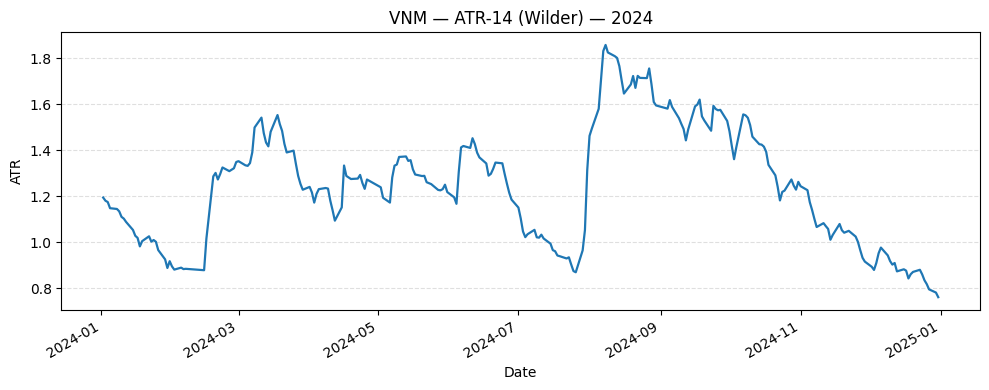

In [24]:
# --- ATR-14 (Wilder) ---
n = 14
prices = prices.sort_values(["symbol","date"]).copy()

prev_close = prices.groupby("symbol", sort=False)["close"].shift(1)
tr = pd.concat([
    prices["high"] - prices["low"],
    (prices["high"] - prev_close).abs(),
    (prices["low"]  - prev_close).abs()
], axis=1).max(axis=1)

def atr_wilder(s: pd.Series, n: int) -> pd.Series:
    x = s.to_numpy(float)
    out = np.full_like(x, np.nan, dtype=float)
    if len(x) >= n:
        out[n-1] = np.nanmean(x[:n])
        for i in range(n, len(x)):
            out[i] = (out[i-1]*(n-1) + x[i]) / n
    return pd.Series(out, index=s.index)

prices["ATR14"] = tr.groupby(prices["symbol"], sort=False).transform(lambda s: atr_wilder(s, n))
print(prices.loc[prices["ATR14"].notna(), ["symbol","date","ATR14"]]
           .head(10).to_string(index=False))

SYM, START, END = "VNM", "2024-01-01", "2025-01-01"
d = prices[(prices["symbol"]==SYM) & (prices["date"]>=START) & (prices["date"]<END)].dropna(subset=["ATR14"])
d.plot(x="date", y="ATR14", figsize=(10,4), lw=1.6, legend=False,
       title=f"{SYM} — ATR-14 (Wilder) — 2024")
plt.xlabel("Date"); plt.ylabel("ATR")
plt.grid(axis="y", ls="--", alpha=0.4)
plt.tight_layout(); plt.show()

## On-Balance Volume (OBV)

On-Balance Volume (OBV) is a cumulative volume-based indicator that relates trading volume to price movements.  
It attempts to measure buying and selling pressure.

**Definition:**

$$
OBV_t =
\begin{cases} 
OBV_{t-1} + V_t, & \text{if } C_t > C_{t-1} \\
OBV_{t-1} - V_t, & \text{if } C_t < C_{t-1} \\
OBV_{t-1}, & \text{if } C_t = C_{t-1}
\end{cases}
$$

where  
- $(V_t$): volume at time $t$,  
- $(C_t$): closing price at time $t$.  

Rising OBV → volume confirms upward price trend (buying pressure).  
Falling OBV → volume confirms downward price trend (selling pressure).  
Divergence between OBV and price may indicate potential reversals.



In [4]:
# --- Standardize volume column ---
vol_col = next((c for c in prices.columns if c.strip().lower() == "volume"), None)
if vol_col is None:
    raise ValueError("DataFrame không có cột 'volume' (vd: 'volume', 'Volume', ...)")

prices.rename(columns={vol_col: "volume"}, inplace=True)
prices["volume"] = prices["volume"].astype(str).str.replace(r"[^\d.]", "", regex=True)
prices["volume"] = pd.to_numeric(prices["volume"], errors="coerce").fillna(0)

symbol       date           OBV
   BID 2014-01-24  0.000000e+00
   BID 2014-01-27  0.000000e+00
   BID 2014-02-06 -2.784300e+08
   BID 2014-02-07 -5.809500e+08
   BID 2014-02-10 -1.474662e+10
   BID 2014-02-11 -1.085212e+10
   BID 2014-02-12 -1.111252e+10
   BID 2014-02-13 -1.144852e+10
   BID 2014-02-14 -1.229910e+10
   BID 2014-02-17 -1.173478e+10


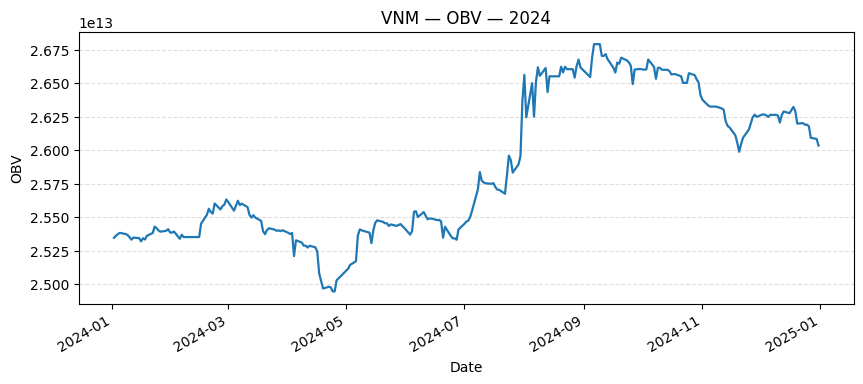

In [26]:
# --- OBV ---
g = prices.groupby("symbol", sort=False)
chg = g["close"].transform(lambda s: s.diff())
direction = np.sign(chg).fillna(0)
prices["OBV"] = (direction * prices["volume"]).groupby(prices["symbol"]).cumsum()

m = prices["OBV"].notna()
print(prices.loc[m, ["symbol","date","OBV"]].head(10).to_string(index=False))

SYM, START, END = "VNM", "2024-01-01", "2025-01-01"
d = prices[(prices["symbol"]==SYM) & (prices["date"]>=START) & (prices["date"]<END)].dropna(subset=["OBV"])
d.plot(x="date", y="OBV", figsize=(10,4), lw=1.6, legend=False, title=f"{SYM} — OBV — 2024")
plt.xlabel("Date"); plt.ylabel("OBV")
plt.grid(axis="y", ls="--", alpha=0.4)
plt.show()

## Chaikin Money Flow (CMF-20)

Chaikin Money Flow (CMF) measures the amount of Money Flow Volume over a specified period (commonly 20 days).  
It captures the relationship between price and volume to assess buying/selling pressure.

**Step 1 — Money Flow Multiplier (MFM):**

$$
MFM_t = \frac{(C_t - L_t) - (H_t - C_t)}{H_t - L_t}
= \frac{2C_t - H_t - L_t}{H_t - L_t}
$$

**where**
- $C_t$: closing price at time $t$  
- $H_t$: high price at time $t$  
- $L_t$: low price at time $t$

**Step 2 — Money Flow Volume (MFV):**

$$
MFV_t = MFM_t \times V_t
$$

with $V_t$ the volume at time $t$.

**Step 3 — Chaikin Money Flow (CMF):**

For window length $k$ (commonly $k=20$):

$$
CMF_t^{(k)} = \frac{\sum_{i=0}^{k-1} MFV_{t-i}}{\sum_{i=0}^{k-1} V_{t-i}}
$$

**Interpretation**
- $CMF > 0$ → buying pressure (accumulation)  
- $CMF < 0$ → selling pressure (distribution)  
- The farther CMF is from zero, the stronger the pressure

**Typical setting:** $k=20$.


symbol       date     CMF20
   BID 2014-03-03 -0.161369
   BID 2014-03-04  0.010173
   BID 2014-03-05 -0.002968
   BID 2014-03-06 -0.008763
   BID 2014-03-07 -0.015148
   BID 2014-03-10  0.061402
   BID 2014-03-11  0.113027
   BID 2014-03-12  0.099442
   BID 2014-03-13  0.096888
   BID 2014-03-14  0.127183


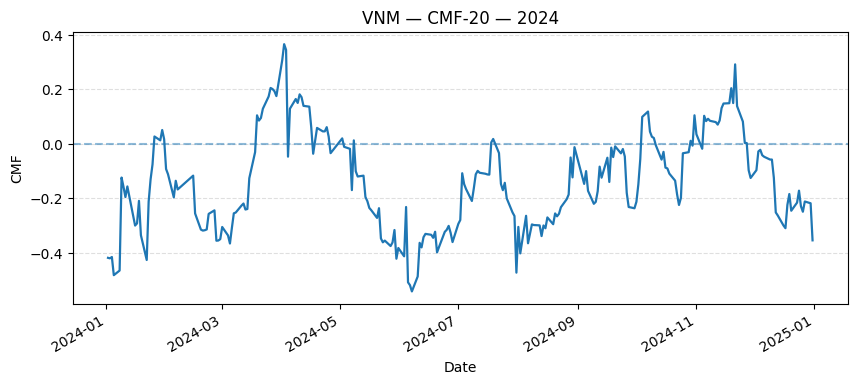

In [27]:
# --- CMF-20 ---
k = 20

hl  = (prices["high"] - prices["low"]).replace(0, np.nan)
mfm = ((prices["close"] - prices["low"]) - (prices["high"] - prices["close"])) / hl
mfv = mfm.fillna(0) * prices["volume"]

sum_mfv = mfv.groupby(prices["symbol"]).transform(lambda s: s.rolling(k, min_periods=k).sum())
sum_vol = prices["volume"].groupby(prices["symbol"]).transform(lambda s: s.rolling(k, min_periods=k).sum())
prices["CMF20"] = sum_mfv / sum_vol

m = prices["CMF20"].notna()
print(prices.loc[m, ["symbol","date","CMF20"]].head(10).to_string(index=False))

SYM, START, END = "VNM", "2024-01-01", "2025-01-01"
d = prices[(prices["symbol"]==SYM) & (prices["date"]>=START) & (prices["date"]<END)].dropna(subset=["CMF20"])
ax = d.plot(x="date", y="CMF20", figsize=(10,4), lw=1.6, legend=False, title=f"{SYM} — CMF-20 — 2024")
ax.axhline(0, ls="--", alpha=0.5)
ax.set_xlabel("Date"); ax.set_ylabel("CMF")
ax.grid(axis="y", ls="--", alpha=0.4)
plt.show()

# Backtest

In [5]:
from backtesting import Backtest, Strategy, set_bokeh_output
from backtesting.lib import crossover
from backtesting.test import SMA

C:\Users\Nguyen Thao\AppData\Local\Programs\Python\Python313\Lib\site-packages\backtesting\_plotting.py:55: UserWarning:

Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.



Loading BokehJS ...

# Backtesting Framework

**Execution model.** Signals are generated on close; orders execute on the same bar (`trade_on_close=True`).  
**Costs.** A transaction fee of 10 bps is applied; slippage can be added for robustness.  
**Capital.** Initial capital is 100,000,000 VND.  
**Positioning.** Long-only in these examples; sizing follows the engine defaults unless stated.

**Note.** Any open positions at the end of the sample can be finalized (`finalize_trades=True`) to include them in performance statistics.


## Strategy 1 — SMA Crossover (20, 50)

**Overview**  
This is a trend-following strategy that uses two simple moving averages to detect medium-term trends.  
The idea is that when the short-term average rises above the long-term average, the market is likely moving into an uptrend.  
When the short-term average falls below the long-term average, the uptrend is considered broken.

**Trading Rules**  
- Enter long when SMA(20) crosses above SMA(50)  
- Exit when SMA(20) crosses below SMA(50)

**Interpretation**  
The strategy captures sustained upward moves and avoids short-term noise.  
It is simple, systematic, and often used as a benchmark for trend-following systems.

In [15]:
# === SMA20–SMA50 Backtest (using precomputed columns) ===
SYM, START, END = "VNM", "2006-01-01", "2025-12-31"

data_bt = (
    prices.loc[(prices["symbol"]==SYM) & (prices["date"]>=START) & (prices["date"]<END),
               ["date","open","high","low","close","volume","SMA20","SMA50"]]
          .dropna(subset=["SMA50"])
          .rename(columns={"date":"Date","open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})
          .set_index("Date")
          .sort_index()
)

class SmaCross(Strategy):
    def init(self):
        self.sma20 = self.I(lambda v: v, self.data.SMA20)
        self.sma50 = self.I(lambda v: v, self.data.SMA50)

    def next(self):
        if self.sma20[-2] <= self.sma50[-2] and self.sma20[-1] > self.sma50[-1]:
            self.position.close(); self.buy()
        elif self.sma20[-2] >= self.sma50[-2] and self.sma20[-1] < self.sma50[-1]:
            self.position.close()

bt = Backtest(data_bt, SmaCross, cash=100_000_000, commission=0.001, trade_on_close=True)
stats = bt.run()
print(stats)
bt.plot(open_browser=False)

Backtest.run:   0%|          | 0/4865 [00:00<?, ?bar/s]

C:\Users\Nguyen Thao\AppData\Local\Temp\ipykernel_28900\3682228456.py:25: UserWarning:

Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.



Start                     2006-04-05 00:00:00
End                       2025-10-03 00:00:00
Duration                   7121 days 00:00:00
Exposure Time [%]                    47.88327
Equity Final [$]              126818322.92484
Equity Peak [$]                 240003508.756
Commissions [$]                12861638.70196
Return [%]                           26.81832
Buy & Hold Return [%]               -24.32099
Return (Ann.) [%]                     1.23801
Volatility (Ann.) [%]                27.27739
CAGR [%]                              0.84432
Sharpe Ratio                          0.04539
Sortino Ratio                         0.05704
Calmar Ratio                          0.01893
Alpha [%]                            43.08234
Beta                                  0.66872
Max. Drawdown [%]                   -65.41108
Avg. Drawdown [%]                     -14.067
Max. Drawdown Duration     6792 days 00:00:00
Avg. Drawdown Duration      772 days 00:00:00
# Trades                          

GridPlot(id='p1736', ...)

## Strategy 2 — RSI Mean Reversion (RSI-14, Buy <30 / Exit >70)

**Overview**  
This is a mean-reversion strategy that uses the Relative Strength Index (RSI) to find oversold and overbought conditions.  
The idea is that prices tend to rebound after extreme declines and lose momentum after strong rallies.

**Trading Rules**  
- Enter long when RSI(14) < 30 (oversold)  
- Exit when RSI(14) > 70 (overbought)

**Interpretation**  
The strategy works well in sideways or range-bound markets where reversals are common.  
It performs poorly in strong trending markets because RSI can stay oversold or overbought for extended periods.


In [19]:
# === Backtest RSI14 (precomputed) ===
SYM, START, END = "VNM", "2006-01-01", "2025-12-31"

data_bt = (
    prices.loc[(prices["symbol"]==SYM) & (prices["date"]>=START) & (prices["date"]<END),
               ["date","open","high","low","close","volume","RSI14_Wilder"]]
          .dropna(subset=["RSI14_Wilder"])
          .rename(columns={"date":"Date","open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})
          .set_index("Date")
          .sort_index()
)

class RsiMeanRevert(Strategy):
    os, ob = 30, 70
    def init(self):
        self.rsi = self.I(lambda v: v, self.data.RSI14_Wilder)

    def next(self):
        if self.rsi[-1] < self.os and not self.position.is_long:
            self.position.close(); self.buy()
        elif self.rsi[-1] > self.ob and self.position.is_long:
            self.position.close()

bt = Backtest(data_bt, RsiMeanRevert, cash=100_000_000, commission=0.001, trade_on_close=True)
stats = bt.run()
print(stats)
bt.plot(open_browser=False)

Backtest.run:   0%|          | 0/4900 [00:00<?, ?bar/s]

Start                     2006-02-15 00:00:00
End                       2025-10-03 00:00:00
Duration                   7170 days 00:00:00
Exposure Time [%]                    49.21445
Equity Final [$]              221554675.52626
Equity Peak [$]               305171393.27226
Commissions [$]                 9684289.73374
Return [%]                          121.55468
Buy & Hold Return [%]                11.45455
Return (Ann.) [%]                     4.17511
Volatility (Ann.) [%]                20.84755
CAGR [%]                              2.83535
Sharpe Ratio                          0.20027
Sortino Ratio                         0.31059
Calmar Ratio                           0.0854
Alpha [%]                             118.093
Beta                                  0.30221
Max. Drawdown [%]                   -48.89046
Avg. Drawdown [%]                   -10.10334
Max. Drawdown Duration     1702 days 00:00:00
Avg. Drawdown Duration      242 days 00:00:00
# Trades                          

GridPlot(id='p2146', ...)

## Strategy 3 — Bollinger Bands Breakout (MA20 ± 2σ)

**Overview**  
This is a volatility breakout strategy that uses Bollinger Bands to identify large price movements.  
The bands are built from a 20-day moving average and two standard deviations.  
When the price closes outside the bands, it suggests that volatility is expanding and a strong move may follow.

**Trading Rules**  
- Enter long when Close > Upper Band  
- Exit when Close < MA20 (default)  
- Exit when Close < Lower Band (if lower-exit option is used)

**Interpretation**  
The strategy aims to capture breakouts after periods of low volatility.  
Using MA20 as exit makes trades shorter and more reactive.  
Using the lower band as exit holds trades longer but increases risk.


In [20]:
# === Bollinger Breakout ===
SYM, START, END = "VNM", "2006-01-01", "2025-12-31"

data_bt = (
    prices.loc[(prices["symbol"]==SYM) & (prices["date"]>=START) & (prices["date"]<END),
               ["date","open","high","low","close","volume","BB_MA20","BB_UP","BB_LO"]]
          .dropna(subset=["BB_LO"])
          .rename(columns={"date":"Date","open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})
          .set_index("Date")
          .sort_index()
)

class BBreakout(Strategy):
    use_lower_exit = False  # True: exit < BB_LO; False: exit < BB_MA20
    def init(self):
        # register precomputed bands
        self.ma = self.I(lambda v: v, self.data.BB_MA20)
        self.up = self.I(lambda v: v, self.data.BB_UP)
        self.lo = self.I(lambda v: v, self.data.BB_LO)

    def next(self):
        c, ma, up, lo = self.data.Close[-1], self.ma[-1], self.up[-1], self.lo[-1]
        if c > up and not self.position.is_long:
            self.position.close(); self.buy()
        if self.position.is_long and ((not self.use_lower_exit and c < ma) or (self.use_lower_exit and c < lo)):
            self.position.close()

bt = Backtest(data_bt, BBreakout, cash=100_000_000, commission=0.001, trade_on_close=True)
stats = bt.run()
print(stats)
bt.plot(open_browser=False)

Backtest.run:   0%|          | 0/4895 [00:00<?, ?bar/s]

Start                     2006-02-22 00:00:00
End                       2025-10-03 00:00:00
Duration                   7163 days 00:00:00
Exposure Time [%]                    29.63644
Equity Final [$]              127167692.48862
Equity Peak [$]                254817667.6555
Commissions [$]                23849168.89138
Return [%]                           27.16769
Buy & Hold Return [%]                -2.69841
Return (Ann.) [%]                     1.24471
Volatility (Ann.) [%]                21.28493
CAGR [%]                              0.84911
Sharpe Ratio                          0.05848
Sortino Ratio                         0.07339
Calmar Ratio                          0.02096
Alpha [%]                            28.29521
Beta                                  0.41784
Max. Drawdown [%]                   -59.39569
Avg. Drawdown [%]                   -13.80763
Max. Drawdown Duration     5884 days 00:00:00
Avg. Drawdown Duration      648 days 00:00:00
# Trades                          

GridPlot(id='p2535', ...)